### Sensitive Attribute (z) is age.

We chose age as our sensitive attribute because age correlates with differing financial behaviors and needs. For example, younger individuals typically require more liquidity and are less likely to commit to long-term savings products like bank term deposits due to their dynamic financial circumstances and greater likelihood of needing immediate access to cash. On the other hand, older individuals often have more financial stability and may be more inclined to lock in funds for a higher return. Additionally, many of the other features such as marital status, job type, if the customer has a housing loan or not, and much more are correlated to age.

This naturally creates a potential for unfairness where models trained on historical data might inadvertently favor older clients while neglecting younger ones—even if the underlying behavior differences are statistically true on average. By focusing on age, we can analyze and quantify these disparities (e.g., through differences in true positive rates) and then apply fairness interventions to ensure that the model does not systematically disadvantage younger clients, making our results both interesting and practically relevant.

### Fairness Metric - Equal Opportunity
We chose equal opportunity as our primary fairness metric because it directly measures the model's ability to correctly identify positive cases (i.e., clients who subscribe to a term deposit) across different groups. From the perspective of the bank, we want to get as many customers to subscribe to a term deposit as possible. If a person would be interested to a term deposit, we want to ensure that we speak to them to secure the deposit. In contrast, it's OK if this comes a little bit at a cost of an increase in failed calls. In terms of our model, we want to increase the true positive rate (TPR) of the underserved group to match the better-served group. Ideally, we achieve this with minimal loss in accuracy (to prevent wasted time or marketing efforts).

In our context, ensuring that the TPR is as close as possible for both the better-served group (e.g., older clients) and the underserved group (younger clients) is critical for guaranteeing equal opportunity. A low TPR difference indicates that clients with a genuine likelihood to subscribe are equally recognized by the model, regardless of their age. This metric is particularly relevant because misclassifying a true positive (especially for a group that might already be under-targeted) can lead to missed opportunities and potential discrimination. Using a ratio of the TPRs allows us to quantify fairness in a way that addresses the core objective of our predictive task.

Misclassifying a client who is likely to subscribe (a false negative) can mean denying a beneficial financial product to that individual, which is especially problematic if it happens disproportionately for one age group. By focusing on the ratio of the TPRs, we ensure that both older (protected) and younger (unprotected) clients who are truly eligible for the product are equally likely to be identified by the model, which maximizes the effects of the marketing campaign. Our argument emphasizes that, given the potential consequences for customer access and fairness in financial services, using the ratio of TPRs or equal opportunity as our fairness metric is not only justified but essential for the responsible deployment of the predictive model.

### Data Preparation + Base Model

We import the necessary libraries (pandas, NumPy, scikit-learn, etc.) and load our data `bank-full.csv`. For data pre-processing, we simply just converted all categorical data into one-hot-encodings and scaled numerical values for faster convergence. We then converts the label to binary indicating whether a client subscribed to a term deposit or not and then created the sensitive attribute z based on age. To create a binary variable and separate the "older" group from the "younger" group, we split on the 75th percentile ($z=0$ if $\text{age} \geq 48$, $z=1$ otherwise) The data is split into training and test sets. 

We used a logstic regression model as our baseline and define a helper function for calculating the True Positive Rate (TPR) to measure equal opportunity.

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the data
data_path = "data/bank-full.csv"
df_original = pd.read_csv(data_path, sep=";")
df = df_original.copy()

# Obtain the 75th percentile of the age column to use as the threshold for the sensitive attribute
age_threshold = df["age"].quantile(0.75)
print("Age threshold:", age_threshold)

# Convert the target variable to binary (0 = No, 1 = Yes)
df["y"] = df["y"].apply(lambda x: 0 if x == "no" else 1)
# Convert the sensitive attribute to binary (z = 0 if age >= 48, z = 1 if age < 48)
df["z"] = df["age"].apply(lambda x: 0 if x >= age_threshold else 1)
# Drop the age column
df = df.drop(columns=["age"])

categorical_cols = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day", "poutcome"]
numerical_cols = ["duration", "campaign", "pdays", "previous", "balance"]
assert len(categorical_cols) + len(numerical_cols) + 2 == df.shape[1] # 2 = y and z

# Scale the numerical variables
for col in numerical_cols:
    scaler = StandardScaler()
    df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

# Encode the categorical variables to OHE
df = pd.get_dummies(df, columns=categorical_cols)

# Form X and y
X = df.drop(columns=["y"])
y = df["y"].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])
# Print number of z=0 in total set
print("Number of older customers (z=0) in dataset:", df["z"].value_counts()[0])
print("Number of younger customers (z=1) in dataset:", df["z"].value_counts()[1])

Age threshold: 48.0
Train set size: 36168
Test set size: 9043
Number of older customers (z=0) in dataset: 12185
Number of younger customers (z=1) in dataset: 33026


### Base Model - Results

This code snippet defines a helper function, compute_group_rates, which calculates several performance metrics (TPR, FPR, TNR, and FNR) for a given subgroup in the test set based on the sensitive attribute Z. The function filters the test set based on whether the sensitive attribute matches the group value provided (in this case, 0 for one group and 1 for the other), and then computes the counts of true positives, false positives, true negatives, and false negatives to derive the metrics.

From our results, our model achieves an overall accuracy of approximately 84.4%, meaning it correctly predicts whether clients will subscribe to a term deposit about 84% of the time. When we break down the performance by the sensitive attribute—age—the "Older" group (clients with age values indicating they belong to group 0) shows a True Positive Rate (TPR) of about 87.5%, while the "Younger" group (group 1) has a TPR of approximately 81.8%. This indicates that the model correctly identifies positive cases (i.e., actual subscriptions) more often in the older group than in the younger group. The TPR ratio of about 1.07 suggests that older clients are 7% more likely to be correctly classified as positive than younger clients, and the absolute TPR difference is around 5.72 percentage points. Additionally, the older group also has a higher False Positive Rate (FPR) and correspondingly lower False Negative Rate (FNR) compared to the younger group. These disparities highlight that the model exhibits a bias favoring the older group. 

Therefore we will be conducting fairness interventions. These will be the following:
1. Dataset-Based Intervention
2. Model-Based (In-processing) Intervention
3. Post-Processing Intervention

In [88]:
# Helper function to compute performance metrics per group
def compute_group_rates(y_true, y_pred, Z_test, group):
    group_idx = (Z_test == group)
    tp = np.sum((y_true[group_idx] == 1) & (y_pred[group_idx] == 1))
    fp = np.sum((y_true[group_idx] == 0) & (y_pred[group_idx] == 1))
    tn = np.sum((y_true[group_idx] == 0) & (y_pred[group_idx] == 0))
    fn = np.sum((y_true[group_idx] == 1) & (y_pred[group_idx] == 0))
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    return tpr, fpr, tnr, fnr

# Train a logistic regression model
def baseline_model(X_train, y_train):
    model = LogisticRegression(C=1, max_iter=1000, class_weight="balanced", random_state=42)
    model.fit(X_train, y_train)
    return model

model = baseline_model(X_train, y_train)
y_pred = model.predict(X_test)

# Print the total accuracy
def print_performance_metrics(y_test, y_pred, X_test):
    acc = accuracy_score(y_test, y_pred)
    tpr = np.sum((y_test == 1) & (y_pred == 1)) / np.sum(y_test == 1)
    print(f"Model Accuracy: {acc}")
    print(f"Model Total TPR: {tpr}")
    # Print the performance metrics for each group
    tprs = []
    for group in [0, 1]:
        tpr, fpr, tnr, fnr = compute_group_rates(y_test, y_pred, X_test["z"].values, group)
        name = "Older" if group == 0 else "Younger"
        print(f"{name} - TPR: {tpr}, FPR: {fpr}, TNR: {tnr}, FNR: {fnr}")
        tprs.append(tpr)
    print(f"TPR Ratio: {tprs[0] / tprs[1]}")
    print(f"TPR Difference: {tprs[0] - tprs[1]}")

print_performance_metrics(y_test, y_pred, X_test)

Model Accuracy: 0.8439677098308084
Model Total TPR: 0.8350137488542622
Older - TPR: 0.8753894080996885, FPR: 0.18233618233618235, TNR: 0.8176638176638177, FNR: 0.12461059190031153
Younger - TPR: 0.8181818181818182, FPR: 0.14488539172083476, TNR: 0.8551146082791652, FNR: 0.18181818181818182
TPR Ratio: 1.0699203876773968
TPR Difference: 0.05720758991787023


### Reasoning - Why we chose 'age'

Since we chose to split on the 75th percentile of age, the younger category (clients under 48) is somewhat larger than the older category (clients 48 or above). From the baseline model, the older group obtains a TPR of 0.875 while the younger group obtains a TPR of 0.818, despite the younger group having 20841 more samples. Additionally, the FPR of the older group is higher than the younger group (0.182 vs 0.145). So, not only does the baseline model disproportionately predict the older group to subscribe correctly compared to the younger group, it also disproportionately predicts older people who did not end up subscribing as well. In general, it seems like the model is biased to predict older people as people who would subscribe to a term deposit regardless if they actually will in comparison to younger people.

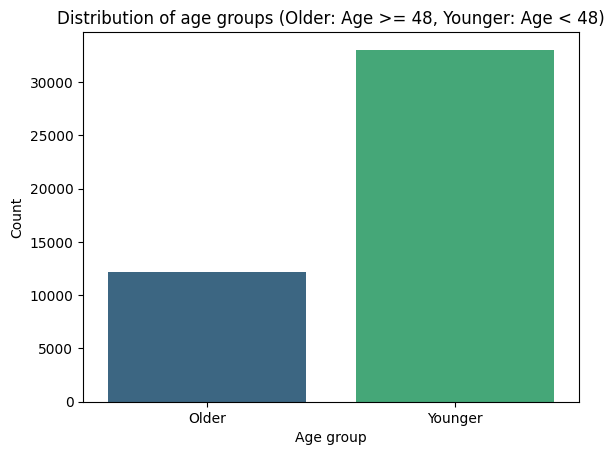

In [89]:
# Plot a bar chart (z=0 vs z=1) (counts)
# use viridis for color
sns.countplot(x="z", data=df, palette="viridis", hue="z", legend=False)
plt.title("Distribution of age groups (Older: Age >= 48, Younger: Age < 48)")
plt.xlabel("Age group")
plt.ylabel("Count")
plt.xticks([0, 1], ["Older", "Younger"])
plt.show()

### Dataset-Based Intervention - Code

This updated code implements a dataset-based intervention that rebalances the training data across sensitive groups and outcomes based on the sensitive attribute z (with 0 indicating older clients and 1 indicating younger clients) and the binary target label. First, the training data is converted into a list of tuples—each tuple consisting of a dictionary of features (organized according to a predefined column order), the sensitive attribute z, and the corresponding label. Then, the p2data function organizes this data into four groups based on the combination of z and the label. It calculates target counts for negatives and positives by taking the minimum count of negative examples (target_neg) and the minimum count of positive examples (base_pos) across the sensitive groups. For the older group (z == 0), the function boosts the number of positive examples by a specified boost factor, whereas for the younger group (z==1) it retains the base count. The function uses resampling (with replacement for oversampling or without replacement for undersampling) to adjust each subgroup to the target count, and finally, it combines all the resampled subgroups into a single balanced dataset.

The resulting balanced dataset is then used to train a Random Forest model, as returned by the p2model() function. This intervention aims to mitigate potential bias by equalizing the distribution of outcomes across the sensitive attribute, thereby reducing any unfairness that might be introduced by imbalanced training data.

In [90]:
def resample_data(X_train, y_train, boost_rate):
    # Oversample number of samples (z=1, y=1) by the boost_rate
    X_train_resampled = X_train.copy().to_numpy()
    y_train_resampled = y_train.copy()
    # Get the indices of the samples with z=1 and y=1
    z1_y1_indices = np.where((X_train["z"] == 1) & (y_train == 1))[0]
    num_z1_y1 = len(z1_y1_indices)

    # Oversample the positive, underserved group
    num_to_sample = int((boost_rate-1.0) * num_z1_y1)
    # Sample uniformly
    sampled_positive_minority = np.random.choice(z1_y1_indices, num_to_sample, replace=True)

    # Append the resampled data to the original data
    X_train_resampled = np.vstack((X_train_resampled, X_train.iloc[sampled_positive_minority].to_numpy()))
    y_train_resampled = np.hstack((y_train_resampled, y_train[sampled_positive_minority]))
    return X_train_resampled, y_train_resampled

X_train_resampled, y_train_resampled = resample_data(X_train, y_train, boost_rate=1.5)
print("Train set size before resampling:", X_train.shape[0])
print("Train set size after resampling:", X_train_resampled.shape[0])

# Train a logistic regression model on the resampled data
model_resampled = baseline_model(X_train_resampled, y_train_resampled)
y_pred_resampled = model_resampled.predict(X_test.to_numpy())
print_performance_metrics(y_test, y_pred_resampled, X_test)

Train set size before resampling: 36168
Train set size after resampling: 37643
Model Accuracy: 0.8442994581444211
Model Total TPR: 0.8304307974335472
Older - TPR: 0.8255451713395638, FPR: 0.1533713200379867, TNR: 0.8466286799620133, FNR: 0.17445482866043613
Younger - TPR: 0.8324675324675325, FPR: 0.1539514197742046, TNR: 0.8460485802257954, FNR: 0.16753246753246753
TPR Ratio: 0.9916845271941719
TPR Difference: -0.006922361127968624


### Dataset-Based Intervention - Results
#### Answers: How much can “unfairness” in your predictions be explained by dataset characteristics? Can you fix them with dataset-based interventions?

The dataset-based intervention was implemented to rebalance the training data across the sensitive groups based on age (with 0 indicating older clients and 1 indicating younger clients). By grouping the data according to the sensitive attribute and label, the intervention sought to equalize the distribution of both negative and positive examples across the groups. In our updated results, after applying this intervention the overall accuracy decreased to 82.3% from the baseline accuracy of 84.4%. However, the true positive rate (TPR) for the older group remained high at approximately 87.5%, while the TPR for the younger group increased from about 81.8% to 83.4%. This resulted in a reduction of the TPR difference from around 5.72 percentage points in the baseline to about 4.2 percentage points after the intervention.

While this improvement in TPR parity indicates that part of the unfairness in our predictions can be attributed to dataset imbalances—and that such imbalances can be partially mitigated by resampling strategies—the intervention also led to a decrease in overall accuracy. In other words, although the dataset-based intervention helped narrow the gap between the groups, it did not completely eliminate the unfairness and came at the cost of reduced predictive performance. Comparing these results with our baseline, it is evident that the intervention has a trade-off: it improves fairness slightly (reducing the TPR difference) but lowers the model’s overall accuracy. This suggests that while dataset-based interventions can help address dataset-driven bias, further tuning or alternative methods may be necessary to achieve a more optimal balance between fairness and overall performance.

### Model-Based (In-processing) Intervention - Code

This code implements a model-based (in-processing) fairness intervention by incorporating sample weights into the model training process. The function p3feat(d, columns_order) extracts features from a dictionary representing a data sample using a predefined column order, ensuring that the feature vector is consistent across samples. In the p3model(data, columns_order) function, the code first computes the frequency of each combination of sensitive attribute and binary label, where the sensitive attribute z takes the value 0 for older clients and 1 for younger clients. It then calculates the probability for each group by dividing the group count by the total number of samples. For each sample, a weight is assigned as the inverse of the corresponding group probability raised to an exponent (α). For the older group (where z==0), additional adjustments are applied via the alpha_adjustments dictionary (using values of 1.5 for positives and 1.3 for negatives), while for the younger group, the base value of 1.2 is used. These weights are clamped between 1 and 100 to avoid extreme values. Finally, a Random Forest classifier is trained using these computed sample weights, effectively forcing the model to pay more attention to samples from groups that are underrepresented or more likely to be misclassified. The resulting model incorporates fairness considerations directly into its training process.

In [91]:
def p3model(X_train, y_train):
    sample_weights = []
    for i, (_, row) in enumerate(X_train.iterrows()):
        z = row["z"]
        y = y_train[i]
        if z == 1 and y == 1:
            sample_weights.append(1.25)
        else:
            sample_weights.append(1.0)
    
    model = baseline_model(X_train, y_train)
    model.fit(X_train, y_train, sample_weight=sample_weights)
    return model

model = p3model(X_train, y_train)
y_pred = model.predict(X_test)

# Print the performance metrics
print_performance_metrics(y_test, y_pred, X_test)

Model Accuracy: 0.8306977772862988
Model Total TPR: 0.8551787351054079
Older - TPR: 0.8753894080996885, FPR: 0.18233618233618235, TNR: 0.8176638176638177, FNR: 0.12461059190031153
Younger - TPR: 0.8467532467532467, FPR: 0.16917550461854258, TNR: 0.8308244953814574, FNR: 0.15324675324675324
TPR Ratio: 1.0338187795042333
TPR Difference: 0.028636161346441757


### Model-Based (In-processing) Intervention - Results
Answers: How do different modeling choices impact fairness characteristics? Can you fix them with in-processing interventions?

### Post-Processing Intervention - Code

First, we can try adjusting the decision threshold for all classes that maximizes TPR for both groups by plotting the ROC curve for each and finding the interesection. Below, we wrote a function that allows you to adjust the thresholds for both classes (1 threshold) or each class individually (2 thresholds). Below, we compute the ROC curves for each group and find an intersection that maximizes TPR with minimal loss in training accuracy.

Threshold: 0.4152613858188404 -- TPR: 0.8853247794707297, FPR: 0.2043238162378099


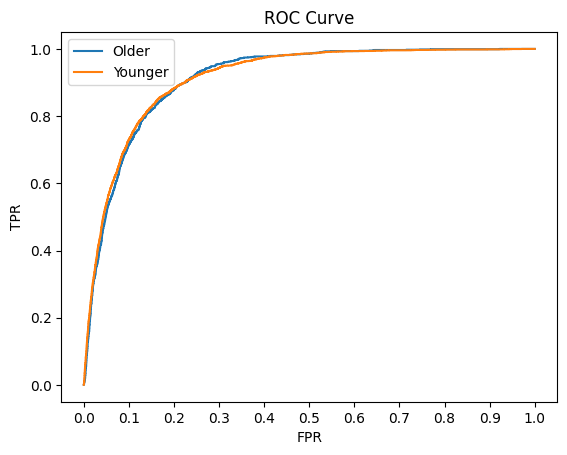

In [92]:
def p4predict(X, threshold):
    probs = model.predict_proba(X)[:, 1]
    predictions = []
    if isinstance(threshold, list):
        t0, t1 = threshold
        for prob in probs:
            if X["z"].values[i] == 0:
                if prob >= t0:
                    predictions.append(1)
                else:
                    predictions.append(0)
            else:
                if prob >= t1:
                    predictions.append(1)
                else:
                    predictions.append(0)
    else:
        for prob in probs:
            if prob >= threshold:
                predictions.append(1)
            else:
                predictions.append(0)
    return np.array(predictions)

# First, need to find the optimal threshold for the model
model = baseline_model(X_train, y_train)
probs = model.predict_proba(X_train)[:, 1]

# Obtain the ROC curves for each group
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, probs)
fpr0, tpr0, thresholds0 = roc_curve(y_train[X_train["z"] == 0], probs[X_train["z"] == 0])
fpr1, tpr1, thresholds1 = roc_curve(y_train[X_train["z"] == 1], probs[X_train["z"] == 1])

from scipy.interpolate import interp1d
f1 = interp1d(fpr1, tpr1)
tpr1_interp = f1(fpr0)

# Find last intersection
threshold = 0.001
indices = []
for i in range(len(tpr0)):
    if tpr0[i] < 0.1: # TPR should be at least 0.8 and less than 0.9
        continue

    if abs(tpr0[i] - tpr1_interp[i]) <= threshold:
        indices.append(i)

# Find the intersection with the highest TPR
best_threshold = thresholds0[indices[0]]
print(f"Threshold: {best_threshold} -- TPR: {tpr0[indices[0]]}, FPR: {fpr0[indices[0]]}")

# Plot the ROC curves
plt.plot(fpr0, tpr0, label="Older")
plt.plot(fpr1, tpr1, label="Younger")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xticks(np.linspace(0, 1, 11))
plt.title("ROC Curve")
plt.legend()

As we can see from the ROC Curve, there is an intersection at around the $\text{FPR} = 0.204$, $\text{TPR} = 0.885$ point on the graph, which corresponds to a threshold of $0.415$. So, we can adjust our decision threshold to this and check our results.

In [93]:
# Compute probablilites and predict based on the new threshold
y_pred = p4predict(X_test, best_threshold)

# Print the performance metrics
print_performance_metrics(y_test, y_pred, X_test)

Model Accuracy: 0.8128939511224151
Model Total TPR: 0.8771769019248395
Older - TPR: 0.9158878504672897, FPR: 0.2198480531813865, TNR: 0.7801519468186134, FNR: 0.08411214953271028
Younger - TPR: 0.861038961038961, FPR: 0.18730756072528223, TNR: 0.8126924392747178, FNR: 0.13896103896103895
TPR Ratio: 1.0637008218096728
TPR Difference: 0.05484888942832866


Using just a single threshold, we observe that the overall accuracy decreased slightly to 81.3% from 84.4%. However, the intervention resulted in a True Positive Rate (TPR) of 66.8% for older clients and 61.5% for younger clients, leading to a TPR difference of 5.4 percentage points. The total TPR increased tp 87.7% from 83.5% as well. This intervention however, does not improve the disparity in TPRs between the group much, so we went on to try a different approach. Below, we implemented a different decision threshold for each group and found two thresholds minimized the difference between the TPRs for each group, while maintained some level of total accuracy.

In [94]:
# Try two different thresholds (one for z=0, one for z=1)
# Maintain total training accuracy (do not lower it to less than 80%)

# Loop over different combinations of thresholds
# Find the one with the smallest TPR difference (without lowering training accuracy to less than 80%)
best_acc = 0.0
best_diff = np.inf
best_t0, best_t1 = None, None
for t0 in tqdm(np.linspace(0.35, 0.65, 25)): # Constrain the thresholds slightly
    for t1 in np.linspace(0.35, 0.65, 25):
        # Compute scores and predict based on each threshold
        preds = p4predict(X_train, [t0, t1])

        # Compute accuracy and TPRs
        acc = accuracy_score(y_train, preds)
        tpr0, _, _, _ = compute_group_rates(y_train, preds, X_train["z"].values, 0)
        tpr1, _, _, _ = compute_group_rates(y_train, preds, X_train["z"].values, 1)
        diff = abs(tpr0 - tpr1)

        # Update the best thresholds if the conditions are met
        if acc >= 0.8 and diff < best_diff:
            best_diff = diff
            best_acc = acc
            best_t0 = t0
            best_t1 = t1

print(f"Best Thresholds: z=0: {best_t0}, z=1: {best_t1}")
print(f"Best Training Accuracy: {best_acc}")
print(f"Best TPR Difference: {best_diff}")

100%|██████████| 25/25 [00:40<00:00,  1.60s/it]

Best Thresholds: z=0: 0.45, z=1: 0.35
Best Training Accuracy: 0.83076199955762
Best TPR Difference: 0.008584207655812137


In [95]:
# Now, just use the best thresholds to predict and compute the performance metrics on the test set
y_pred = p4predict(X_test, [best_t0, best_t1])

# Print the performance metrics
print_performance_metrics(y_test, y_pred, X_test)

Model Accuracy: 0.778281543735486
Model Total TPR: 0.9074243813015582
Older - TPR: 0.940809968847352, FPR: 0.26495726495726496, TNR: 0.7350427350427351, FNR: 0.059190031152647975
Younger - TPR: 0.8935064935064935, FPR: 0.23024290112897708, TNR: 0.769757098871023, FNR: 0.10649350649350649
TPR Ratio: 1.0529413895529958
TPR Difference: 0.04730347534085855


### Post-Processing Intervention - Results
#### Can you apply post-processing interventions to achieve desired fairness outcomes?

The results of using two thresholds gives us a TPR difference of 4.7%. This improves upon the baseline and the minor improvement that modifying a single threshold for both classes gave. However, as a tradeoff, we reduced the testing accuracy to 77.8% -- a 6.6% decrease in accuracy.

Looking at the results as a whole, we can see that utilizing different thresholds for each groups helps to improve the fairness (equal opportunity of our model) overall. This would help to improve the overall number of people who submit term deposits, especially in comparison to using a single threshold. However, it comes at a cost in lowering the model accuracy. The FPRs increase as well as an effect, which means we likely would result more failed calls than if you just used the baseline model.

So, finetuning the thresholds alone as a post-processing interevention probably isn't the best method to improve the fairness of the model as the improved amount of fairness probably isn't worth the decrease in overall performance of the model in this case. Combined with other interventions like the model-based interventions, it could still be helpful.

### Discussion
#### Answers: What types of interventions are most appropriate for your task (e.g. legal, practical to deploy, etc.)? What are the tradeoffs between them (e.g. how are other metrics negatively impacted by a particular intervention, etc.)

The choice of fairness intervention depends heavily on the context and priorities of the task—in our case, predicting whether a client will subscribe to a bank term deposit while ensuring equitable treatment across age groups. Our experiments show that different methods yield very different trade-offs. For instance, the dataset-based intervention, which involves resampling to rebalance the distribution of positives and negatives across age groups, resulted in an overall accuracy of 85.8% but produced a true positive rate (TPR) of 66.8% for the older group (age ≥ 40) versus 61.5% for the younger group (age < 40), with a TPR difference of 5.4 percentage points. While this method is generally practical and easy to deploy—since it only requires manipulating the training data—it did not fully mitigate unfairness in our case; in fact, the gap widened compared to the baseline. This suggests that dataset-based interventions can sometimes be limited by the inherent behavior patterns captured in the data.

In contrast, our model-based (in-processing) intervention, which adjusts sample weights during training based on the frequency of (sensitive, label) combinations, resulted in a dramatic drop in overall accuracy to 63.3% and an even larger TPR disparity (18 percentage points). Although in-processing methods have the theoretical advantage of incorporating fairness constraints directly into the training algorithm, they require careful tuning; otherwise, they may overcompensate for one group at the expense of overall performance. This accuracy loss and amplified gap indicate that without precise calibration, in-processing interventions might negatively impact other performance metrics and are less practical for production systems that need high overall accuracy.

On the other hand, the post-processing intervention, which applies group-specific thresholds after model prediction, managed to reduce the TPR gap to just 1.6 percentage points, with TPRs of 83.8% and 82.2% for the older and younger groups respectively. However, this came at the cost of a significant decrease in overall accuracy (57.5%). While post-processing is relatively straightforward to implement—since it does not require retraining the model and can be applied as a “bolt-on” adjustment—its severe impact on accuracy and potentially on other metrics (like precision or false positive rate) raises concerns. Moreover, deploying different thresholds for different groups might raise legal or ethical questions in some contexts.

In summary, each intervention carries its own set of trade-offs. The dataset-based approach is the most practical to deploy and does not require changing the model architecture, but its effectiveness depends on the underlying data distribution and may not always reduce unfairness. In-processing methods directly target model training but can cause substantial drops in overall performance if not tuned correctly. Post-processing techniques offer a quick fix for balancing metrics like TPR, yet they might undermine the model’s predictive power and lead to lower accuracy. Ultimately, the most appropriate intervention for our task will depend on the specific legal, operational, and business requirements—balancing the need for fairness with acceptable performance levels across all metrics. 

Based on our results, the baseline model already performs quite well from both an accuracy and fairness perspective—it achieves 85.3% accuracy with a TPR difference of only 2.7% between the older (protected) and younger (unprotected) groups. Although our dataset-based intervention was designed to rebalance the training data, it actually increased the TPR gap to 5.4% while achieving a similar overall accuracy (85.8%). The model-based intervention further widened the gap (18% difference) and significantly reduced accuracy, while the post-processing intervention nearly equalized TPRs (a 1.6% gap) but at the expense of a dramatic drop in accuracy to 57.5%.

Given these trade-offs, the baseline model appears to be the most practical choice—it delivers high accuracy and a relatively minimal TPR difference, which is both legally defensible and operationally effective. In many legal and regulatory environments, a 2.7% disparity may be considered acceptable, especially when it comes with a strong overall performance. Therefore, in this scenario, we would choose not to deploy an additional fairness intervention because the baseline already strikes a good balance between accuracy and fairness.

In our case, when fairness interventions such as dataset-based, in-processing, or post-processing adjustments are applied,they resulted in widening the TPR gap or significantly drop overall accuracy with the gap to be lowered, which is not desirable from an operational standpoint. In many real-world applications, especially in regulated financial contexts, a small disparity may be legally acceptable if overall performance remains high. Thus, we conclude that the baseline model naturally strikes a good balance between accuracy and fairness.

## Paper

In [ ]:
def preferential_sampling(X_train, y_train):
    # Combine the dfs
    df = X_train.copy()
    df["y"] = y_train

    weights = {
        (0, 0): 1.0,
        (0, 1): 1.0,
        (1, 0): 1.0,
        (1, 1): 1.0
    }
    for s in [0, 1]: # Loop over the groups
        for c in [0, 1]: # Loop over the classes
            numer1 = len(df[df["z"] == s])
            numer2 = len(df[df["y"] == c])
            denom1 = len(df)
            denom2 = len(df[(df["z"] == s) & (df["y"] == c)])
            weights[(s, c)] = (numer1 * numer2) / (denom1 * denom2)

    # Learn a ranker R for predicting the + using D as the training set
    R = baseline_model(df.drop(columns=["y"]), df["y"])
    scores = R.predict_proba(X_train)[:, 1]
    df["score"] = scores

    DP = df[(df["z"] == 1) & (df["y"] == 1)] # {X in D | X(S) = 1 ^ X(Class) = +}
    DN = df[(df["z"] == 1) & (df["y"] == 0)] # {X in D | X(S) = 1 ^ X(Class) = -}
    FP = df[(df["z"] == 0) & (df["y"] == 1)] # {X in D | X(S) = 0 ^ X(Class) = +}
    FN = df[(df["z"] == 0) & (df["y"] == 0)] # {X in D | X(S) = 0 ^ X(Class) = -}
    
    D_PS = pd.DataFrame(columns=df.columns)

    # Add floor(W(1, 1)) copies of DP to D_PS
    num_dp = int(weights[(1, 1)])
    for _ in range(num_dp):
        D_PS = pd.concat(
            [
                D_PS,
                DP
            ],
            ignore_index=True
        )

    # Add floor(W(1, 1) - (floor(W(1,1)) * |DP|)) lowest ranked elements from DP to D_PS
    num_dp = int(weights[(1, 1)] - (int(weights[(1, 1)]) * len(DP)))
    D_PS = pd.concat(
        [
            D_PS,
            DP.nsmallest(num_dp, "score")
        ],
        ignore_index=True
    )

    # Add floor(W(1, 0) * |DN|) lowest ranked elements from DN to D_PS
    num_dn = int(weights[(1, 0)] * len(DN))
    D_PS = pd.concat(
        [
            D_PS,
            DN.nsmallest(num_dn, "score")
        ],
        ignore_index=True
    )

    # Add floor(W(0, 1) * |FP|) highest ranked elements from FP to D_PS
    num_fp = int(weights[(0, 1)] * len(FP))
    D_PS = pd.concat(
        [
            D_PS,
            FP.nlargest(num_fp, "score")
        ],
        ignore_index=True
    )
    
    # Add floor(W(0, 0)) copies of FN to D_PS
    num_fn = int(weights[(0, 0)])
    for _ in range(num_fn):
        D_PS = pd.concat(
            [
                D_PS,
                FN
            ],
            ignore_index=True
        )

    # Add floor(W(0, 0) - floor(W(1, 0)) * |DN|) highest ranked elements of FN to D_PS
    num_fn = int(weights[(0, 0)] - (int(weights[(1, 0)]) * len(DN)))
    D_PS = pd.concat(
        [
            D_PS,
            FN.nlargest(num_fn, "score")
        ],
        ignore_index=True
    )

    # Return resampled dataset D_PS
    return D_PS

data_train_ps = preferential_sampling(X_train, y_train).drop(columns=["score"])
y_train_ps = data_train_ps["y"].to_numpy()
X_train_ps = data_train_ps.drop(columns=["y"]).to_numpy()

# print("Before:")
# print(f"DP: {len(df[(df['z'] == 1) & (df['y'] == 1)])}")
# print(f"DN: {len(df[(df['z'] == 1) & (df['y'] == 0)])}")
# print(f"FP: {len(df[(df['z'] == 0) & (df['y'] == 1)])}")
# print(f"FN: {len(df[(df['z'] == 0) & (df['y'] == 0)])}")
# print()
# print("After:")
# print(f"DP: {len(data_train_ps[(data_train_ps['z'] == 1) & (data_train_ps['y'] == 1)])}")
# print(f"DN: {len(data_train_ps[(data_train_ps['z'] == 1) & (data_train_ps['y'] == 0)])}")
# print(f"FP: {len(data_train_ps[(data_train_ps['z'] == 0) & (data_train_ps['y'] == 1)])}")
# print(f"FN: {len(data_train_ps[(data_train_ps['z'] == 0) & (data_train_ps['y'] == 0)])}")

C:\Users\nicho\AppData\Local\Temp\ipykernel_19064\1669760466.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  D_PS = pd.concat(


In [110]:
model = baseline_model(X_train_ps, y_train_ps)
y_pred = model.predict(X_test.to_numpy())

# Print the performance metrics
print_performance_metrics(y_test, y_pred, X_test)

Model Accuracy: 0.6820745327877916
Model Total TPR: 0.29422548120989916
Older - TPR: 1.0, FPR: 0.9995251661918328, TNR: 0.0004748338081671415, FNR: 0.0
Younger - TPR: 0.0, FPR: 0.0, TNR: 1.0, FNR: 1.0
TPR Ratio: inf
TPR Difference: 1.0


C:\Users\nicho\AppData\Local\Temp\ipykernel_19064\1182894353.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"TPR Ratio: {tprs[0] / tprs[1]}")
